In [1]:
from qumcmc.basic_utils import *
from qumcmc.prob_dist import *
from qumcmc.energy_models import *
from qumcmc.classical_mcmc_routines import *

### Quantum circuit construction

In [2]:
from qulacs import QuantumState, QuantumCircuit
from qulacsvis import circuit_drawer
from scipy.linalg import expm
from qulacs.gate import DenseMatrix
from qulacs.gate import X, Y, Z  

In [44]:
def initialise_qc(n_spins: int, bitstring: str) -> QuantumCircuit :
    """
    Initialises a quantum circuit with n_spins number of qubits in a state defined by "bitstring"    
    """
    qc_in=QuantumCircuit(qubit_count=n_spins)
    len_str_in = len(bitstring)
    assert len_str_in==qc_in.get_qubit_count(), "len(bitstring) should be equal to number_of_qubits/spins"

    for i in range(0,len(bitstring)):
        if bitstring[i]=="1":
            qc_in.add_X_gate(len_str_in - 1 - i)
    #circuit_drawer(qc_in,"mpl")
    return qc_in

In [48]:
def fn_qc_h1(num_spins: int, gamma, alpha, h:list, delta_time=0.8) -> QuantumCircuit :
    """
    Create a Quantum Circuit for time-evolution under
    hamiltonain H1 (described in the paper) 

    ARGS:
    ----
    num_spins: number of spins in the model
    gamma: float
    alpha: float
    h: list of field at each site
    delta_time: total evolution time time/num_trotter_steps
    """
    a=gamma
    #b_list=[-(1 - gamma) * alpha * hj for hj in h]
    b_list=list( ((gamma-1)*(alpha))* np.array(h))
    # need to change this part
    # list_unitaries = [DenseMatrix(index=j,
    #     matrix=np.round(expm(-1j*delta_time*(a*X(2).get_matrix()+b_list[j]*Z(2).get_matrix())))
    #                     )
    #     for j in range(0, num_spins)
    # ]
    # need to replace part

    qc = QuantumCircuit(num_spins)
    for j in range(0, num_spins):
        #qc.append(list_unitaries[j], [num_spins - 1 - j])
        unitary_gate=DenseMatrix(index=num_spins-1-j,
                        matrix=np.round(expm(-1j*delta_time*(a*X(2).get_matrix()+b_list[j]*Z(2).get_matrix())),decimals=6)
                        )
        qc.add_gate(unitary_gate)
    
    #circuit_drawer(qc)
    # print("qc is:"); print(qc.draw())
    return qc

In [56]:
def fn_qc_h2(J:np.array, alpha:float, gamma:float, delta_time) -> QuantumCircuit :
    """
    Create a Quantum Circuit for time-evolution under
    hamiltonain H2 (described in the paper)

    ARGS:
    ----
    J: interaction matrix, interaction between different spins
    gamma: float
    alpha: float
    delta_time: (default=0.8, as suggested in the paper)total evolution time time/num_trotter_steps
    """
    num_spins=np.shape(J)[0]
    qc_for_evol_h2=QuantumCircuit(num_spins)
    theta_list = [
        -2 * J[j, j + 1] * (1 - gamma) * alpha * delta_time
        for j in range(0, num_spins - 1)
    ]# only near neighbour interaction based model! it seems.
    # print("theta_list:");print(theta_list)
    #theta is:
    pauli_z_index=[3,3]## Z tensor Z
    for j in range(0,num_spins-1):
        target_list=[num_spins-1-j,num_spins-1-(j+1)]#num_spins-1-j,num_spins-1-(j+1)
        angle=-1*theta_list[j]# -1* because in qulacs rotn are exp(+i pauli_1 tensor pauli_2 )
        qc_for_evol_h2.add_multi_Pauli_rotation_gate(index_list=target_list,pauli_ids=pauli_z_index,angle=angle)
    
    #circuit_drawer(qc_for_evol_h2)
    return qc_for_evol_h2

In [32]:
check_rzz=QuantumCircuit(2)
check_rzz.add_multi_Pauli_rotation_gate(index_list=[0,1],pauli_ids=[3,3],angle=-0.45)
st=QuantumState(2)
check_rzz.update_quantum_state(st)
st.get_vector()

array([0.97479411-0.22310636j, 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ])

In [36]:
def fn_qc_h2_new(J:np.array, alpha:float, gamma:float, delta_time) -> QuantumCircuit :
    """
    # updated version.
    Create a Quantum Circuit for time-evolution under
    hamiltonain H2 (described in the paper)

    ARGS:
    ----
    J: interaction matrix, interaction between different spins
    gamma: float
    alpha: float
    delta_time: (default=0.8, as suggested in the paper)total evolution time time/num_trotter_steps
    """
    num_spins=np.shape(J)[0]
    qc_for_evol_h2=QuantumCircuit(num_spins)
    # calculating theta_jk
    upper_triag_without_diag=np.triu(J,k=1)
    theta_array=(-2*(1-gamma)*alpha*delta_time)*upper_triag_without_diag
    pauli_z_index=[3,3]## Z tensor Z
    for j in range(0,num_spins-1):
        for k in range(j+1,num_spins):
            print("j,k is:",(j,k))
            target_list=[num_spins-1-j,num_spins-1-k]#num_spins-1-j,num_spins-1-(j+1)
            angle=theta_array[j,k]
            qc_for_evol_h2.add_multi_Pauli_rotation_gate(index_list=target_list,pauli_ids=pauli_z_index,angle=angle)
    
    #circuit_drawer(qc_for_evol_h2,"mpl")
    return qc_for_evol_h2

In [14]:
def trottered_qc_for_transition(num_spins: int, qc_h1: QuantumCircuit, qc_h2: QuantumCircuit, num_trotter_steps: int) -> QuantumCircuit:
    """ Returns a trotter circuit (evolution_under_h2 X evolution_under_h1)^(r-1) (evolution under h1)"""
    qc_combine=QuantumCircuit(num_spins)
    for _ in range(0,num_trotter_steps-1):
        qc_combine.merge_circuit(qc_h1)
        qc_combine.merge_circuit(qc_h2)
    qc_combine.merge_circuit(qc_h1)
    return qc_combine

In [15]:
def combine_2_qc(init_qc: QuantumCircuit, trottered_qc: QuantumCircuit) -> QuantumCircuit:
    """ Function to combine 2 quantum ckts of compatible size.
        In this project, it is used to combine initialised quantum ckt and quant ckt meant for time evolution
    """
    num_spins=init_qc.get_qubit_count()
    qc=QuantumCircuit(num_spins)
    qc.merge_circuit(init_qc)
    qc.merge_circuit(trottered_qc)
    return qc

In [16]:
######## classical loop acceptance state #####
def classical_loop_accepting_state(
    s_init: str, s_prime: str, energy_s: float, energy_sprime: float, temp=1
) -> str:
    """
    Accepts the state "sprime" with probability A ( i.e. min(1,exp(-(E(s')-E(s))/ temp) )
    and s_init with probability 1-A.
    """
    delta_energy = energy_sprime - energy_s  # E(s')-E(s)
    exp_factor = np.exp(-delta_energy / temp)
    acceptance = min(
        1, exp_factor
    )  # for both QC case as well as uniform random strategy, the transition matrix Pij is symmetric!
    # coin_flip=np.random.choice([True, False], p=[acceptance, 1-acceptance])
    new_state = s_init
    if acceptance >= np.random.uniform(0, 1):
        new_state = s_prime
    return new_state

In [58]:
################################################################################################
##  QUANTUM MARKOV CHAIN CONSTRUCTION ##
################################################################################################

def run_qc_quantum_step(
    qc_initialised_to_s: QuantumCircuit, model: IsingEnergyFunction, alpha, n_spins: int
) -> str:

    """
    Takes in a qc initialized to some state "s". After performing unitary evolution U=exp(-iHt)
    , circuit is measured once. Function returns the bitstring s', the measured state .

    ARGS:
    ----
    qc_initialised_to_s:
    model:
    alpha:
    n_spins:
    
    """

    h = model.get_h# and not model.get_h() anymore
    J = model.get_J# and not model.get_J() anymore

    # init_qc=initialise_qc(n_spins=n_spins, bitstring='1'*n_spins)
    np.random.seed(12)
    gamma = np.round(np.random.uniform(0.25, 0.6), decimals=2)
    time = np.random.choice(list(range(2, 12)))  # earlier I had [2,20]
    delta_time = 0.8 
    num_trotter_steps = int(np.floor((time / delta_time)))
    # print(f"gamma:{gamma}, time: {time}, delta_time: {delta_time}, num_trotter_steps:{num_trotter_steps}")
    # print(f"num troter steps: {num_trotter_steps}")
    qc_evol_h1 = fn_qc_h1(n_spins, gamma, alpha, h, delta_time)
    qc_evol_h2 = fn_qc_h2(J, alpha, gamma, delta_time=delta_time)
    trotter_ckt = trottered_qc_for_transition(
        n_spins, qc_evol_h1, qc_evol_h2, num_trotter_steps=num_trotter_steps
    )
    qc_for_mcmc = combine_2_qc(qc_initialised_to_s, trotter_ckt)# i can get rid of this!
    #print("number of qubits in qc_for_mcmc:",qc_for_mcmc.get_qubit_count())
    # run the circuit
    q_state=QuantumState(qubit_count=n_spins)
    q_state.set_zero_state()
    qc_for_mcmc.update_quantum_state(q_state)
    # print("q_state vector after updation:")
    # print(np.round(q_state.get_vector(),decimals=4))
    state_obtained=q_state.sampling(sampling_count=1)[0]
    #print("samples:");print(q_state.sampling(sampling_count=50))
    #print("amplitude measurement:");print(np.round(q_state.get_amplitude(comp_basis=17),decimals=4))
    state_obtained_binary=f"{state_obtained:0{n_spins}b}"
    return state_obtained_binary

In [52]:
# define the model
np.random.seed(0)# should always be in the same cell!  
n_spins = 10

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= (n_spins, n_spins) )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.01 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')
model.alpha

0.47352304041476556

In [51]:
qc_initialised_to_s=initialise_qc(n_spins=n_spins,bitstring="1101")
alpha=np.round(model.alpha,decimals=4)
run_qc_quantum_step(
    qc_initialised_to_s, model=model, alpha=alpha, n_spins=n_spins
)

                   ___   
                  |PR |  
------------------|   |--
                  |   |  
           ___    |   |  
          |PR |   |   |  
----------|   |---|   |--
          |   |   |___|  
   ___    |   |          
  |PR |   |   |          
--|   |---|   |----------
  |   |   |___|          
  |   |                  
  |   |                  
--|   |------------------
  |___|                  
q_state vector after updation:
[-0.0193+0.088j  -0.2215-0.1188j  0.3175-0.4512j -0.0218+0.0033j
 -0.049 +0.0397j  0.2576-0.0245j -0.0442+0.1857j -0.0466+0.j
 -0.0004-0.0018j  0.2101+0.0277j -0.1848+0.1468j  0.0121+0.0018j
  0.0951+0.0584j -0.2041-0.4671j  0.2601+0.2539j  0.0397+0.0868j]


'0010'

In [59]:
np.random.seed(12)# this part is correct :D
## added by neel to check something
gamma = np.round(np.random.uniform(0.25, 0.6), decimals=2)
check_h1=fn_qc_h1(num_spins=n_spins,
gamma=gamma,alpha=model.alpha,h=h,delta_time=0.8)

check_state=QuantumState(n_spins)
check_state.set_zero_state()
check_h1.update_quantum_state(check_state)
print("checking the statevector obtained:")
print(np.round(check_state.get_vector(),decimals=6))

checking the statevector obtained:
[ 0.91618 +0.022707j  0.      -0.22425j   0.007408-0.224148j
 -0.054875-0.000453j  0.003705-0.22424j  -0.054875+0.000453j
 -0.054865-0.00136j   0.      +0.013429j]


In [42]:
np.random.seed(1221)
## added by neel to check something
gamma = np.round(np.random.uniform(0.25, 0.6), decimals=2)
check_h2=fn_qc_h2(J=J,alpha=model.alpha,gamma=gamma,delta_time=0.8)
check_state=QuantumState(n_spins)
check_state.set_zero_state()
check_h2.update_quantum_state(check_state)
print("checking the statevector obtained:")
print(np.round(check_state.get_vector(),decimals=6))

theta_list:
[-1.3341932552916034]
angle is:
1.3341932552916034
   ___   
  |PR |  
--|   |--
  |   |  
  |   |  
  |   |  
--|   |--
  |___|  
checking the statevector obtained:
[0.785621+0.618708j 0.      +0.j       0.      +0.j
 0.      +0.j      ]


In [52]:
qc_initialised_to_s=initialise_qc(n_spins=n_spins,bitstring="1100")
alpha=np.round(model.alpha,decimals=4)
run_qc_quantum_step(
    qc_initialised_to_s, model=model, alpha=alpha, n_spins=n_spins
)

q_state vector after updation:
[ 0.2182-0.0114j -0.143 -0.1307j  0.0218+0.0033j  0.1485+0.4675j
  0.214 +0.12j    0.0032+0.1931j -0.1628-0.j     -0.0433+0.183j
  0.2101+0.0277j -0.2393-0.0064j  0.1779-0.155j   0.1605+0.1687j
  0.3266-0.3205j -0.1136+0.062j  -0.054 +0.0958j  0.2256-0.1141j]


'1100'

In [54]:
def quantum_enhanced_mcmc(
    N_hops: int,
    # num_spins: int,
    # num_elems: int,
    model: IsingEnergyFunction,
    # alpha,
    initial_state: Union[None, str] = None,
    return_last_n_states=500,
    return_additional_lists=False,
    temp=1,
):
    """
    version 0.2
    
    ARGS:
    ----
    Nhops: Number of time you want to run mcmc
    model:
    return_last_n_states:
    return_both:
    temp:

    RETURNS:
    -------
    Last 'return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it!
    
    """
    states_obt = []
    all_configs = [f"{k:0{model.num_spins}b}" for k in range(0, 2 ** (model.num_spins))]
    if initial_state == None : 
        initial_state = np.random.choice(all_configs)
    print("starting with: ", initial_state)

    ## initialise quantum circuit to current_state
    qc_s = initialise_qc(n_spins= model.num_spins, bitstring=initial_state)
    current_state = initial_state
    states_obt.append(current_state)
    ## intialise observables
    list_after_transition = []
    list_state_mchain_is_in = []
    poss_states=states(num_spins=model.num_spins)

    for i in tqdm(range(0, N_hops), desc='runnning quantum MCMC steps . ..' ):
        # print("i: ", i)
        # get sprime
        s_prime = run_qc_quantum_step(
            qc_initialised_to_s=qc_s, model=model, alpha=model.alpha, n_spins= model.num_spins
        )
        list_after_transition.append(s_prime)
        # accept/reject s_prime
        energy_s = model.get_energy(current_state)
        #print('s,s_prime is:',(current_state,s_prime))
        energy_sprime = model.get_energy(s_prime)
        next_state = classical_loop_accepting_state(
            current_state, s_prime, energy_s, energy_sprime, temp=temp
        )
        current_state = next_state
        list_state_mchain_is_in.append(current_state)
        states_obt.append(current_state)
        ## reinitiate
        qc_s = initialise_qc(n_spins= model.num_spins, bitstring=current_state)

    # dict_count_return_last_n_states = Counter(
    #     states[-return_last_n_states:]
    # )  # dictionary of occurences for last "return_last_n_states" states
    #
    dict_count_return_last_n_states=dict(zip(poss_states,[0]*(len(poss_states))))
    dict_count_return_last_n_states.update(dict(Counter(states_obt[-return_last_n_states:])))

    if return_additional_lists:
        to_return = (
            dict_count_return_last_n_states,
            list_after_transition,
            list_state_mchain_is_in,
        )
    else:
        to_return = dict_count_return_last_n_states

    return to_return

In [59]:
a,b,c=quantum_enhanced_mcmc(
    N_hops=3000,
    # num_spins: int,
    # num_elems: int,
    model=model,
    # alpha,
    initial_state='1101110111',
    return_last_n_states=10,
    return_additional_lists=True,
    temp=1,
)

runnning quantum MCMC steps . ..:   0%|          | 5/3000 [00:00<01:04, 46.14it/s]

starting with:  1101110111


runnning quantum MCMC steps . ..: 100%|██████████| 3000/3000 [00:46<00:00, 64.89it/s]


In [80]:
### for a small example, compare this thing with earlier qiskit's implementation.

### Was checking something!

earlier:  [1.+0.j 0.+0.j 0.+0.j 0.+0.j]


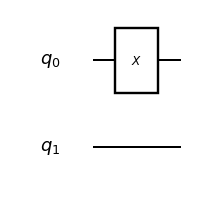

now: [0.+0.j 1.+0.j 0.+0.j 0.+0.j]


In [122]:
from qulacs import QuantumState

n=2
state=QuantumState(n)
state.set_zero_state()
print("earlier: ",state.get_vector())
qc=QuantumCircuit(n)
qc.add_X_gate(0)
circuit_drawer(qc,"mpl")
qc.update_quantum_state(state)
print("now:",state.get_vector())

In [123]:
unique,counts=np.unique(state.sampling(10000),return_counts=True)
dict(zip(unique,counts))

{1: 10000}

state right now: [0.+0.j 1.+0.j 0.+0.j 0.+0.j]


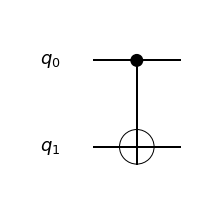

state_now: [0.+0.j 0.+0.j 0.+0.j 1.+0.j]


In [141]:
# same as qiskit indexing convention! goodness !!!!!
from qulacs.gate import CNOT
state_check=QuantumState(qubit_count=2)
state_check.set_computational_basis(0b01)
print("state right now:",state_check.get_vector())
qc=QuantumCircuit(2)
qc.add_CNOT_gate(control=0,target=1)
circuit_drawer(qc,"mpl")
qc.update_quantum_state(state_check)
print("state_now:",state_check.get_vector())